<a href="https://colab.research.google.com/github/LeoneedDev/animal_classification/blob/feat%2Fdata_preprocessing_and_split/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
from dataset.translate import *

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
import wandb

# Import data

In [65]:
def translate_label(dirname: str, mapping: dict[str, str]) -> str:
    translated = mapping.get(dirname, dirname)
    return translated

In [66]:
df = pd.DataFrame()
data = []

for (dirpath, dirnames, filenames) in os.walk("./dataset/raw-img"):
    if filenames:
        label = os.path.basename(dirpath)
        translated_label = translate_label(label, translate_it_to_en)
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            data.append({'label': translated_label, 'filepath': filepath})

df = pd.DataFrame(data)
df

,label,filepath
0,spider,./dataset/raw-img/ragno/OIP-lBJhFJhgyWngJZZ2_P...
1,spider,./dataset/raw-img/ragno/OIP-l6cJZpoJgLVAcPRVHA...
2,spider,./dataset/raw-img/ragno/OIP-rtLifFSC9uZo1wwjpL...
3,spider,./dataset/raw-img/ragno/OIP-52ki9o7uFLChL1VRP3...
4,spider,./dataset/raw-img/ragno/OIP-_yEfOnLnRFkLNROCEp...
...,...,...
26174,cow,./dataset/raw-img/mucca/OIP-b7-TQvKmz-I8ygBJGL...
26175,cow,./dataset/raw-img/mucca/OIP-0h4l2T_792LYTbp1hS...
26176,cow,./dataset/raw-img/mucca/OIP-hJeYf79TUPxT8S-gNr...
26177,cow,./dataset/raw-img/mucca/OIP-TGK7Hz88VJA-76COa0...


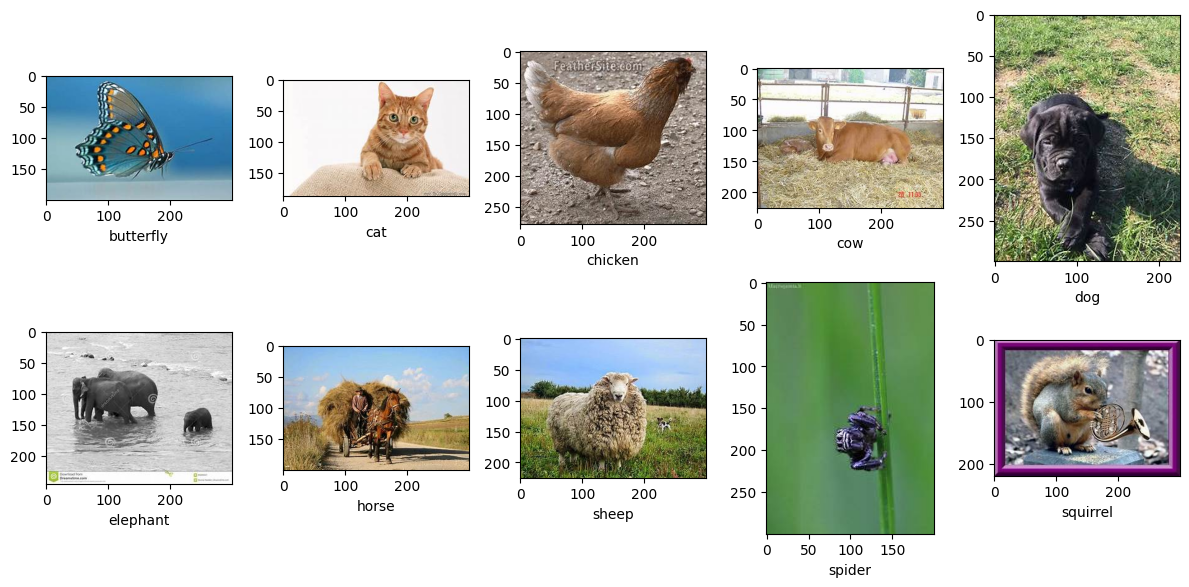

In [67]:
sample_df = df.groupby('label').first().reset_index()
_, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (index, row) in enumerate(sample_df.iterrows()):
    filename =  row["filepath"] # type: ignore
    category =  row["label"] # type: ignore
    img = Image.open(filename).convert("RGB")
    axes[i//5, i%5].imshow(img)
    axes[i//5, i%5].set_xlabel(category)
plt.tight_layout()
plt.show()

# Label encoding

In [68]:
labelEncoding = {label: str(idx) for idx, label in enumerate(df['label'].unique())}
df['label_encoded'] = df['label'].map(labelEncoding)
df.groupby('label_encoded').first().head(df['label'].nunique())

,label,filepath
label_encoded,,
0,spider,./dataset/raw-img/ragno/OIP-lBJhFJhgyWngJZZ2_P...
1,dog,./dataset/raw-img/cane/OIP-lo9xJy4KZGukwCXg5P3...
2,sheep,./dataset/raw-img/pecora/OIP-G09lcDuPS5XSnDpO5...
3,butterfly,./dataset/raw-img/farfalla/OIP-LacCrzYjlv9GD13...
4,squirrel,./dataset/raw-img/scoiattolo/OIP-TH5BEvZTNNn9L...
5,elephant,./dataset/raw-img/elefante/OIP-cE7rRAF8CKqzrtA...
6,cat,./dataset/raw-img/gatto/477.jpeg
7,chicken,./dataset/raw-img/gallina/OIP-D2SdhutnISpccVYj...
8,horse,./dataset/raw-img/cavallo/OIP-sLE5Y_dM9QZLS5Mi...


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          26179 non-null  object
 1   filepath       26179 non-null  object
 2   label_encoded  26179 non-null  object
dtypes: object(3)
memory usage: 613.7+ KB


# Splitting data

In [70]:
def split_data(df: pd.DataFrame, test_size: float, val_size: float, random_state: int):
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df['label_encoded'],
        random_state=random_state
    )

    val_relative_size = val_size / (1 - test_size)

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_relative_size,
        stratify=train_val_df['label_encoded'],
        random_state=random_state
    )

    train_x = train_df['filepath']
    train_y = train_df['label_encoded']

    val_x = val_df['filepath']
    val_y = val_df['label_encoded']

    test_x = test_df['filepath']
    test_y = test_df['label_encoded']

    return train_x, train_y, val_x, val_y, test_x, test_y

In [71]:
train_x, train_y, val_x, val_y, test_x, test_y = split_data(df, test_size=0.3, val_size=0.2, random_state=880055535)

# Pipeline transformations

In this part we want to find mean / std for our dataset for normalization

Resize images to 128x128 because from eda we know that are mean size of images is around 320*252, so resizing to 128x128 will not lose much information but will speed up training process significantly. Also images are have good quality so downsizing is ok.

In [72]:
from image_dataset import ImageDataset
tr = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

dataset = ImageDataset(train_x, train_y, transform=tr)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

mean = 0.
std = 0.
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.5172, 0.5003, 0.4131])
Std: tensor([0.2084, 0.2082, 0.2101])


now we can add normaliser for all pipelines

In [73]:
tr_norm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [74]:
train_dataset = ImageDataset(val_x, val_y, transform=tr)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

train_dataset_norm = ImageDataset(val_x, val_y, transform=tr_norm)
train_loader_norm = DataLoader(train_dataset_norm, batch_size=64, shuffle=True, num_workers=2)

test_dataset = ImageDataset(test_x, test_y, transform=tr_norm)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [75]:
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = None
        self.fc2 = nn.Linear(256, num_classes)
        self.num_classes = num_classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)

        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 256).to(x.device)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [76]:
def predict_all(model, loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)
            p = torch.argmax(logits, dim=1)
            preds.extend(p.cpu().numpy())
    return np.array(preds)

In [77]:
num_classes = len(labelEncoding)

In [78]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.Module, train_loader: DataLoader, num_epochs=5):
    loss_vals=  []
    for epoch in range(num_epochs):
        loss = 0
        epoch_loss= []
        for _, (data, targets) in enumerate(train_loader):
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            loss.backward()

            epoch_loss.append(loss.item())
            optimizer.step()

        loss_vals.append(sum(epoch_loss)/len(epoch_loss))
        print(epoch, "Current Loss:", loss)
    return loss_vals

def evaluate(loader, model):
    """
        @returns: (all_preds, all_targets)
    """
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, pred = scores.max(1)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    return all_preds, all_targets


Adam was used because nowadays it is mostly used optimizer. It combines RMSProp with momentum and bias correction, which adjusts the deviations at the start of the algorithm and speeds up the convergence

## Training the model for check the difference between pipelines with and without normalization

In [79]:
model_regular = SimpleCNN(num_classes).to(device)
loss_vals_regular = train(model_regular, torch.optim.Adam(model_regular.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
model_norm = SimpleCNN(num_classes).to(device)
loss_vals_norm = train(model_norm, torch.optim.Adam(model_norm.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader_norm)

0 Current Loss: tensor(2.1895, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(2.1221, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(2.1132, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(2.0919, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.9174, device='cuda:0', grad_fn=<NllLossBackward0>)
0 Current Loss: tensor(2.2264, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.8497, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(2.1125, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.8096, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.8720, device='cuda:0', grad_fn=<NllLossBackward0>)


after we train our model we can evaluate it on train and test datasets, so we can check if there any difference in accuracy between pipelines with and without normalization

<Axes: >

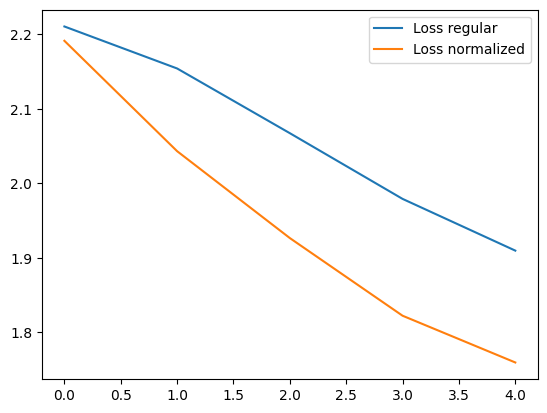

In [80]:
sns.lineplot(x=range(len(loss_vals_regular)), y=loss_vals_regular, label="Loss regular")
sns.lineplot(x=range(len(loss_vals_norm)), y=loss_vals_norm, label="Loss normalized")

## Evaluating the model for both pipelines

### Pipeline without normalization

In [81]:
train_pred_regular, train_target_regular = evaluate(train_loader, model_regular)
test_pred_regular, test_target_regular = evaluate(test_loader, model_regular)
classification_report(train_target_regular, train_pred_regular)
classification_report(test_target_regular, test_pred_regular)

'              precision    recall  f1-score   support\n\n           0       0.68      0.11      0.20      1446\n           1       0.26      0.38      0.31      1459\n           2       0.20      0.05      0.09       546\n           3       0.15      0.70      0.25       634\n           4       0.11      0.01      0.02       559\n           5       0.27      0.05      0.08       434\n           6       0.16      0.12      0.14       500\n           7       0.23      0.08      0.12       929\n           8       0.28      0.26      0.27       787\n           9       0.23      0.32      0.27       560\n\n    accuracy                           0.22      7854\n   macro avg       0.26      0.21      0.17      7854\nweighted avg       0.30      0.22      0.19      7854\n'

### Pipeline with normalization

In [82]:
train_pred_norm, train_target_norm = evaluate(train_loader, model_norm)
test_pred_norm, test_target_norm = evaluate(test_loader, model_norm)

In [83]:
classification_report(train_target_norm, train_pred_norm)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'              precision    recall  f1-score   support\n\n           0       0.20      0.98      0.33       964\n           1       0.37      0.10      0.16       973\n           2       0.24      0.08      0.12       364\n           3       0.00      0.00      0.00       422\n           4       0.00      0.00      0.00       372\n           5       0.00      0.00      0.00       289\n           6       0.00      0.00      0.00       334\n           7       0.15      0.02      0.03       620\n           8       0.21      0.01      0.01       525\n           9       0.50      0.01      0.01       373\n\n    accuracy                           0.21      5236\n   macro avg       0.17      0.12      0.07      5236\nweighted avg       0.20      0.21      0.11      5236\n'

In [84]:
classification_report(test_target_norm, test_pred_norm)

'              precision    recall  f1-score   support\n\n           0       0.45      0.64      0.53      1446\n           1       0.33      0.54      0.41      1459\n           2       0.28      0.39      0.33       546\n           3       0.58      0.21      0.31       634\n           4       0.57      0.01      0.03       559\n           5       0.43      0.03      0.06       434\n           6       0.00      0.00      0.00       500\n           7       0.29      0.38      0.33       929\n           8       0.34      0.38      0.36       787\n           9       0.37      0.17      0.23       560\n\n    accuracy                           0.36      7854\n   macro avg       0.36      0.28      0.26      7854\nweighted avg       0.37      0.36      0.32      7854\n'

Conclusion on the experiments:
Even if normalization is on graphs shows more Loss then without normalization, accuracy for test is more higher with normalization then without it. So normalization helps our model to generalize better on unseen data. Just we need to add more epochs

# Wanddb configuration

In [85]:
# os.environ['WANDB_API_KEY'] = ""
api_key = os.environ.get('WANDB_API_KEY')
if api_key:
    wandb.login(key=api_key)
    print("Logged in to W&B successfully.")
else:
    raise ValueError("W&B API key not found in environment variables.")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Logged in to W&B successfully.


# Augmentation

For augumentations we will add to transformation with normalisation some augumentations such as random resize, crop, random horizontal flip, random color change, random rotation


## Configurations

In [86]:
train_transforms = {
    "baseline": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "light": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "medium": transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    "hard": transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
}

eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

## Testing all configurations

In [87]:
# for transform_name, transform in train_transforms.items():
#     print(f"Training with {transform_name} augmentation")
#     run = wandb.init(project="animal_classification", name=f"augmentation_{transform_name}")
#     train_dataset = ImageDataset(train_x, train_y, transform=transform)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

#     model = SimpleCNN(num_classes).to(device)
#     loss_vals = train(model, torch.optim.Adam(model.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
#     sns.lineplot(x=range(len(loss_vals)), y=loss_vals, label=f"Train loss {transform_name}")
#     print(f"Evaluating model trained with {transform_name} augmentation")
#     test_dataset = ImageDataset(test_x, test_y, transform=eval_transform)
#     test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
#     pred, target = evaluate(test_loader, model)
#     run.log({
#             "train_loss": loss_vals,
#             "transform": transform_name,
#             "test_accuracy": accuracy_score(target, pred),
#             "test_precision": precision_score(target, pred, average='weighted'),
#             "test_recall": recall_score(target, pred, average='weighted'),
#             "test_f1": f1_score(target, pred, average='weighted')
#         })
#     run.finish()

Conclusion on augumentations:
After testing different augumentations we can see that best results shows combination of light version is the best one.

# Random params search

## Baseline transforms

0 Current Loss: tensor(2.1738, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(2.0662, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.9230, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.8638, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.8507, device='cuda:0', grad_fn=<NllLossBackward0>)


<Axes: >

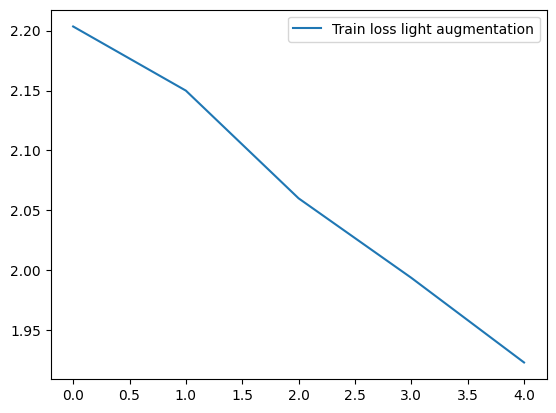

In [88]:
train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

model = SimpleCNN(num_classes).to(device)
loss_vals = train(model, torch.optim.Adam(model.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
sns.lineplot(x=range(len(loss_vals)), y=loss_vals, label=f"Train loss light augmentation")

In [89]:
pred, target = evaluate(test_loader, model)
classification_report(target, pred)

'              precision    recall  f1-score   support\n\n           0       0.70      0.15      0.24      1446\n           1       0.26      0.47      0.33      1459\n           2       0.29      0.12      0.17       546\n           3       0.17      0.59      0.27       634\n           4       0.22      0.03      0.05       559\n           5       0.09      0.03      0.04       434\n           6       0.13      0.03      0.05       500\n           7       0.24      0.16      0.19       929\n           8       0.28      0.31      0.29       787\n           9       0.21      0.28      0.24       560\n\n    accuracy                           0.24      7854\n   macro avg       0.26      0.21      0.19      7854\nweighted avg       0.31      0.24      0.22      7854\n'

## Finding best augumentation parameters

In [90]:
import itertools

config_map_variations = {
    "resize" : [(64, 64), (96, 96), (128, 128),(192, 192), (256, 256)],
    "random_horizontal_flip" : [0.1, 0.3, 0.5, 0.7],
}
keys = list(config_map_variations.keys())
values = list(config_map_variations.values())
combinations = list(itertools.product(*values))

transform_configs = []
for combo in combinations:
    config = dict(zip(keys, combo))
    transform_configs.append(config)
transform_configs

[{'resize': (64, 64), 'random_horizontal_flip': 0.1},
 {'resize': (64, 64), 'random_horizontal_flip': 0.3},
 {'resize': (64, 64), 'random_horizontal_flip': 0.5},
 {'resize': (64, 64), 'random_horizontal_flip': 0.7},
 {'resize': (96, 96), 'random_horizontal_flip': 0.1},
 {'resize': (96, 96), 'random_horizontal_flip': 0.3},
 {'resize': (96, 96), 'random_horizontal_flip': 0.5},
 {'resize': (96, 96), 'random_horizontal_flip': 0.7},
 {'resize': (128, 128), 'random_horizontal_flip': 0.1},
 {'resize': (128, 128), 'random_horizontal_flip': 0.3},
 {'resize': (128, 128), 'random_horizontal_flip': 0.5},
 {'resize': (128, 128), 'random_horizontal_flip': 0.7},
 {'resize': (192, 192), 'random_horizontal_flip': 0.1},
 {'resize': (192, 192), 'random_horizontal_flip': 0.3},
 {'resize': (192, 192), 'random_horizontal_flip': 0.5},
 {'resize': (192, 192), 'random_horizontal_flip': 0.7},
 {'resize': (256, 256), 'random_horizontal_flip': 0.1},
 {'resize': (256, 256), 'random_horizontal_flip': 0.3},
 {'resiz

In [ ]:
from datetime import datetime
time = datetime.now().strftime("%Y%m%d_%H%M")
for item in transform_configs:
    run = wandb.init(project="animal_classification", name=f"rand_search_resized_{item['resize']}_flip_{item['random_horizontal_flip']}_{time}")
    train_transform = transforms.Compose([
        transforms.Resize(item['resize']),
        transforms.RandomHorizontalFlip(p=item['random_horizontal_flip']),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    eval_transform = transforms.Compose([
        transforms.Resize(item['resize']),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    train_dataset = ImageDataset(train_x, train_y, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    test_dataset = ImageDataset(test_x, test_y, transform=eval_transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = SimpleCNN(num_classes).to(device)
    loss_vals = train(model, torch.optim.Adam(model.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
    sns.lineplot(x=range(len(loss_vals)), y=loss_vals, label=f"Train loss resized {item['resize']} flip {item['random_horizontal_flip']}")
    pred, target = evaluate(test_loader, model)
    run.log({
            "train_loss": loss_vals,
            "resize": item['resize'],
            "random_horizontal_flip": item['random_horizontal_flip'],
            "test_accuracy": accuracy_score(target, pred),
            "test_precision": precision_score(target, pred, average='weighted'),
            "test_recall": recall_score(target, pred, average='weighted'),
            "test_f1": f1_score(target, pred, average='weighted')
        })
    run.finish()

0 Current Loss: tensor(1.8854, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.8423, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.9020, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.5919, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.4981, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.1
test_accuracy,0.46117
test_f1,0.45068
test_precision,0.45445
test_recall,0.46117


0 Current Loss: tensor(1.7996, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.7497, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.9277, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.6204, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.5406, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.3
test_accuracy,0.43112
test_f1,0.41242
test_precision,0.42368
test_recall,0.43112


0 Current Loss: tensor(1.9736, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.5398, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.7804, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.4504, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.5653, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.5
test_accuracy,0.44754
test_f1,0.42853
test_precision,0.44868
test_recall,0.44754


0 Current Loss: tensor(2.1192, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.8918, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.5517, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.5896, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.5759, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.7
test_accuracy,0.43927
test_f1,0.41425
test_precision,0.43459
test_recall,0.43927


0 Current Loss: tensor(1.9866, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.8098, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.6852, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.5018, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.2886, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.1
test_accuracy,0.43494
test_f1,0.43109
test_precision,0.44628
test_recall,0.43494


0 Current Loss: tensor(1.8118, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.6896, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.6364, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.6696, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.6556, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.3
test_accuracy,0.43888
test_f1,0.41076
test_precision,0.44707
test_recall,0.43888


0 Current Loss: tensor(1.8431, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.9325, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.7338, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.7986, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.6185, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.5
test_accuracy,0.44105
test_f1,0.42062
test_precision,0.44149
test_recall,0.44105


0 Current Loss: tensor(2.0192, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.7456, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.9260, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.7615, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.5407, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.7
test_accuracy,0.42755
test_f1,0.39926
test_precision,0.42472
test_recall,0.42755


0 Current Loss: tensor(2.0961, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.4226, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.9926, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.8413, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.4643, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.1
test_accuracy,0.44576
test_f1,0.41912
test_precision,0.44216
test_recall,0.44576


0 Current Loss: tensor(1.8709, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.7738, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.5446, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.3015, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.3248, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.3
test_accuracy,0.44742
test_f1,0.43279
test_precision,0.45018
test_recall,0.44742


0 Current Loss: tensor(2.0455, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.6816, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.7394, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.6652, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.6773, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.5
test_accuracy,0.43748
test_f1,0.42808
test_precision,0.44134
test_recall,0.43748


0 Current Loss: tensor(1.7278, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.8180, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.5936, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.3686, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.4248, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.7
test_accuracy,0.44321
test_f1,0.43141
test_precision,0.44031
test_recall,0.44321


0 Current Loss: tensor(2.0043, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.8440, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.6384, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.6255, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.3591, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.1
test_accuracy,0.44118
test_f1,0.41921
test_precision,0.43234
test_recall,0.44118


0 Current Loss: tensor(2.0570, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.6293, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.3624, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.6554, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.6905, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.3
test_accuracy,0.44894
test_f1,0.42663
test_precision,0.44448
test_recall,0.44894


0 Current Loss: tensor(1.9148, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.6208, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.6637, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.6915, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.5533, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.5
test_accuracy,0.44385
test_f1,0.40981
test_precision,0.44256
test_recall,0.44385


0 Current Loss: tensor(1.9793, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.7654, device='cuda:0', grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(1.9117, device='cuda:0', grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(1.7511, device='cuda:0', grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)


random_horizontal_flip,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
random_horizontal_flip,0.7
test_accuracy,0.44423
test_f1,0.41665
test_precision,0.43984
test_recall,0.44423


0 Current Loss: tensor(1.8390, device='cuda:0', grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.6033, device='cuda:0', grad_fn=<NllLossBackward0>)
